# Qcodes example with Alazar ATS 9360

In [11]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

In [2]:
# Command to list all alazar boards connected to the system
ATSdriver.AlazarTech_ATS.find_boards()

[{'bits_per_sample': 12,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'system_id': 1}]

In [3]:
# Create the ATS9870 instrument on the new server "alazar_server"
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')
# Print all information about this Alazar card
ats_inst.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '6.0.0',
 'asopc_type': '1779729248',
 'bits_per_sample': 12,
 'driver_version': '6.0.0',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [4]:
# Instantiate an acquisition controller (In this case we are doing a simple DFT) on the same server ("alazar_server") and 
# provide the name of the name of the alazar card that this controller should control
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

In [6]:
# Configure all settings in the Alazar card
ats_inst.config(clock_source='INTERNAL_CLOCK',
              sample_rate=1_000_000_000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

In [7]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=70,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

In [8]:
# Getting the value of the parameter 'acquisition' of the instrument 'acquisition_controller' performes the entire acquisition 
# protocol. This again depends on the specific implementation of the acquisition controller
acquisition_controller.acquisition()

4.502616118642945

In [9]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'functions': {},
 'name': 'Alazar1',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'inter_delay': 0,
   'label': 'IDN',
   'name': 'IDN',
   'post_delay': 0,
   'raw_value': None,
   'ts': None,
   'unit': '',
   'vals': '<Anything>',
   'value': None},
  'alloc_buffers': {'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS.AlazarParameter',
   'full_name': 'Alazar1_alloc_buffers',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'inter_delay': 0,
   'label': 'Alloc Buffers',
   'name': 'alloc_buffers',
   'post_delay': 0,
   'raw_value': 'DISABLED',
   'ts': '2017-11-09 18:08:02',
   'unit': '',
   'vals': "<Enum: {'ENABLED', 'DISABLED'}>",
   'value':

Started at 2017-11-09 18:08:04
DataSet:
   location = 'data/2017-11-09/#005_AlazarTest_18-08-04'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
Finished at 2017-11-09 18:08:08


<IPython.core.display.Javascript object>


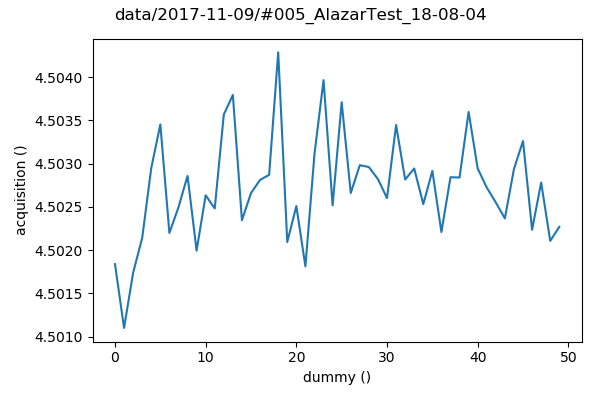

In [10]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)